In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import classification_report

### Data Processing

In [62]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")

In [225]:
test['variety']='Unknown'

In [227]:
data = pd.concat([train,test])

In [63]:
from sklearn import preprocessing

X, Y = train.iloc[:, :-1], train.iloc[:, -1]


In [71]:
train.isnull().sum().sort_values()

id                0
description       0
points            0
variety           0
country          23
province         23
price          3247
dtype: int64

In [233]:
df = data.copy()
df.select_dtypes(include=['object'])

,country,description,province,variety
0,US,A nice starter Pinot for the price. Will intro...,California,Pinot Noir
1,Germany,This wine comes out of the bottle a little cra...,Mosel-Saar-Ruwer,Riesling
2,US,This easy-drinking Pinot Noir offers layers of...,California,Pinot Noir
3,France,"An attractive and ripely fruited Cab, this ope...",France Other,Cabernet Sauvignon
4,US,The vineyard is located in the western part of...,California,Pinot Noir
...,...,...,...,...
14261,US,"The aromas of this rosé of Cabernet Sauvignon,...",Virginia,Unknown
14262,France,This powerful effort is holding back on its ri...,Bordeaux,Unknown
14263,US,This wine consists of all five red Bordeaux va...,California,Unknown
14264,US,"Here's a likeable Chard, with peach, pear and ...",California,Unknown


In [66]:
# see if there are missing entries in the dataset features
categorical_columns = df.select_dtypes(include=['object']).columns
print('the number of categorical columns',len(categorical_columns))
print('the number of columns',len(X.columns))
train.isnull().sum().sort_values()

the number of categorical columns 4
the number of columns 6


id                0
description       0
points            0
variety           0
country          23
province         23
price          3247
dtype: int64

In [67]:
rate1 = round(X.isnull().sum().sort_values()[-3]/len(df)*100,2)
rate2 = round(X.isnull().sum().sort_values()[-2]/len(df)*100,2)
rate3 = round(X.isnull().sum().sort_values()[-1]/len(df)*100,2)
print('the missing rate of country: %s %%' %  rate1)
print('the missing rate of province: %s %%' %  rate2)
print('the missing rate of price: %s %%' %  rate3)

the missing rate of country: 0.04 %
the missing rate of province: 0.04 %
the missing rate of price: 5.69 %


In [234]:
df.fillna({'country': 'Missing', 'province': 'Missing'}, inplace=True)

In [235]:
price_mean = df['price'].mean()
df.fillna({'price':price_mean}, inplace=True)
print('price mean of training data:',price_mean)

price mean of training data: 38.120459158380555


#### encode the categorical variables

In [273]:
X_des = df.description.tolist()
clean_X = df.drop(columns = ['description'])
from sklearn.preprocessing import LabelEncoder 
labelencoder= LabelEncoder() #initializing an object of class LabelEncoder
categorical_columns = clean_X.select_dtypes(include=['object']).columns
for categorical_column in categorical_columns:
    clean_X[categorical_column] = labelencoder.fit_transform(clean_X[categorical_column]) #fitting and transforming the desired categorical column.


In [312]:
variety_idx = clean_X.variety.tolist()
variety = df.variety.tolist()
variety_dic = {}
for i in range(len(variety)):
    if variety_idx[i] not in variety_dic:
        variety_dic[variety_idx[i]]=variety[i]
country_idx = clean_X.country.tolist()
country = df.country.tolist()
country_dic = {}
for i in range(len(country)):
    if country_idx[i] not in country_dic:
        country_dic[country[i]]=country_idx[i]
province_idx = clean_X.province.tolist()
province = df.province.tolist()
province_dic = {}
for i in range(len(province)):
    if province_idx[i] not in province_dic:
        province_dic[province[i]]=province_idx[i]

In [276]:
test_df = clean_X[clean_X.id>57055].drop(columns = ['id','variety'])

In [277]:
train_df = clean_X[clean_X.id<=57055].drop(columns = ['id'])

Counter({4: 10617, 2: 9402, 1: 7577, 5: 7157, 0: 5532, 6: 4151, 8: 3973, 9: 3314, 7: 2851, 3: 2482})


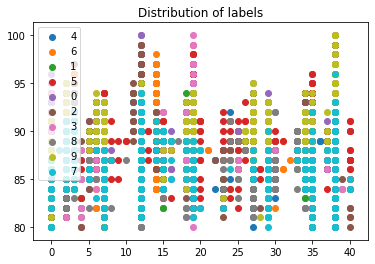

In [78]:
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
# define dataset
y=clean_X.variety.to_numpy()
x=clean_X.to_numpy()
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(x[row_ix, 1], x[row_ix, 2], label=str(label))
pyplot.legend()
pyplot.title('Distribution of labels')
pyplot.show()

## Text processing 

3 steps
- Remove numbers and punctuations
- Remove stop words
- Stem words

In [97]:
import re
# Define a function to remove numbers and punctuations
def remove_num_punc(words):
    # remove all numbers and punctuations
    pattern = r"('(?:\w+))|\\r\\n|\\n|\\r|[^a-zA-Z]"
    clean_words = re.sub(pattern,' ',str(words), flags=re.S)
    words_arr = clean_words.lower().split()
    join_words = ' '.join(words_arr)
    return join_words

In [98]:
# remove stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# List of stopwords
nl_stopwords = stopwords.words('english')
nl_stopwords = set(nl_stopwords)

# Add custom words
nl_stopwords.update(["drink", "now", "wine", "flavor", 
                     'flavors', 'finish', 'palate', 'show', 
                     'nose', 'note', 'taste', 'notes',
                     'also', 'still', 'yet',
                     'feels', 'feel', 'give', 'gives',
                     'come', 'comes', 'need', 'needs',
                     'seems', 'seem', 'ro'
                     'one', 'two'])

def remove_stop_words(words, stop_words=nl_stopwords):
    word_arr = words.split()
    filter_words = [word for word in word_arr if word not in stop_words]
    join_words = ' '.join(filter_words)
    return join_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fuqinwei/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [101]:
#Stem words
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')

def stem_words(words, lang='english'):
    # tokenize words
    tokenized_words = word_tokenize(words, language=lang)
    #stem words
    stemmer = SnowballStemmer(lang)
    stemmed_words = []
    for word in tokenized_words:
        stemmed_words.append(stemmer.stem(word))
    return ' '.join(stemmed_words)

[nltk_data] Downloading package punkt to /Users/fuqinwei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [259]:
desc = df['description']

# Apply NLP to descriptions
desc = desc.apply(remove_num_punc)
desc = desc.apply(remove_stop_words)
desc = desc.apply(stem_words)

# Replace all descriptions with processed descriptiones in DataFrame
df['desc'] = desc

In [260]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(stop_words = nl_stopwords, ngram_range=(1, 3), max_features=300) 
X_train_vec = vec.fit_transform(df['desc'])
from sklearn.feature_extraction.text import TfidfTransformer
tf = TfidfTransformer()
X_tf = tf.fit_transform(X_train_vec)

In [261]:
tfidf = pd.DataFrame(X_tf[0].T.todense(), index=vec.get_feature_names(), columns=["TF-IDF"])
tfidf = tfidf.sort_values('TF-IDF', ascending=False)
print (tfidf.head(25))

                TF-IDF
varieti       0.362033
price         0.333079
silki         0.326757
nice          0.307120
savori        0.304338
smoki         0.297470
pinot         0.272597
touch         0.255584
berri         0.229511
light         0.223377
textur        0.222000
oak           0.206191
spice         0.204411
perfum        0.000000
petit         0.000000
plenti        0.000000
pineappl      0.000000
pinot noir    0.000000
pepper        0.000000
peel          0.000000
pear          0.000000
peach         0.000000
pleasant      0.000000
petit verdot  0.000000
power         0.000000


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [299]:
des_feature = X_tf.toarray()[:57056]
aug_feature = train_df.iloc[:, :-1].to_numpy()
X = np.hstack((des_feature,aug_feature))
Y = clean_X[clean_X.id<=57055]['variety'].to_numpy()

In [300]:
test_des_feature = X_tf.toarray()[57056:]
test_aug_feature = test_df.to_numpy()
test_X = np.hstack((test_des_feature,test_aug_feature))

In [301]:
test_X.shape

(14266, 304)

In [302]:
X.shape

(57056, 304)

In [304]:
Y

array([4, 6, 4, ..., 4, 1, 1])

## Modeling

In [305]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=77)


In [306]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 10,
    'gamma': 0.1,
    'max_depth': 6,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
}

plst = list(params.items())


dtrain = xgb.DMatrix(X_train, y_train)
num_rounds = 500
model = xgb.train(plst, dtrain, num_rounds)


dtest = xgb.DMatrix(X_test)
ans = model.predict(dtest)

[13:12:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:12:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [308]:
cnt1 = 0
cnt2 = 0
for i in range(len(y_test)):
    if ans[i] == y_test[i]:
        cnt1 += 1
    else:
        cnt2 += 1

print("Accuracy: %.2f %% " % (100 * cnt1 / (cnt1 + cnt2)))
print(classification_report(y_test,ans))



Accuracy: 84.69 % 
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1102
           1       0.73      0.79      0.76      1527
           2       0.90      0.94      0.92      1913
           3       0.68      0.50      0.57       480
           4       0.88      0.93      0.90      2088
           5       0.82      0.82      0.82      1379
           6       0.96      0.94      0.95       846
           7       0.91      0.83      0.87       590
           8       0.84      0.83      0.83       784
           9       0.76      0.66      0.71       703

    accuracy                           0.85     11412
   macro avg       0.84      0.81      0.82     11412
weighted avg       0.85      0.85      0.84     11412



In [309]:
d_test = xgb.DMatrix(test_X)
sample_ans = model.predict(d_test)

In [317]:
sample = pd.read_csv('sample.csv')
sample['variety']=[variety_dic[int(var)] for var in sample_ans]
sample.to_csv('output.csv',index=False)


### Logistic regression
- logistic regression is a comprehensive model implemented in binary classification

In [176]:
from sklearn.linear_model import LogisticRegression

In [181]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.reshape(-1))
y_pred = logreg.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [184]:
print(classification_report(y_test.to_numpy(), y_pred))
print('AUC score',roc_auc_score(y_test.to_numpy(), y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      9030
           1       0.76      0.67      0.71      2924

    accuracy                           0.87     11954
   macro avg       0.83      0.80      0.81     11954
weighted avg       0.86      0.87      0.86     11954

AUC score 0.8015406162464986


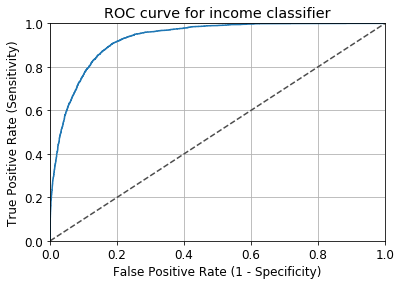

In [198]:
from sklearn.metrics import roc_curve, auc
y_predict = logreg.predict(X_test)
y_pred_quant = logreg.predict_proba(X_test)[:, 1]
y_pred_bin = logreg.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for income classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

### SVM

In [187]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(X_train, y_train.to_numpy())
print("Test Accuracy of SVM Algorithm: {:.2f}%".format(svm.score(X_test,y_test.to_numpy())*100))
print(classification_report(y_test.to_numpy(), svm.predict(X_test)))

Test Accuracy of SVM Algorithm: 87.65%
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      9030
           1       0.78      0.69      0.73      2924

    accuracy                           0.88     11954
   macro avg       0.84      0.81      0.83     11954
weighted avg       0.87      0.88      0.87     11954



In [192]:
print('AUC score',roc_auc_score(y_test.to_numpy(), svm.predict(X_test)))

AUC score 0.8145544264217316


### Naive Bayes 

In [189]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train.to_numpy())
print("Accuracy of Naive Bayes: {:.2f}%".format(nb.score(X_test,y_test.to_numpy())*100))
print(classification_report(y_test.to_numpy(), nb.predict(X_test)))

Accuracy of Naive Bayes: 74.96%
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      9030
           1       0.49      0.92      0.64      2924

    accuracy                           0.75     11954
   macro avg       0.73      0.81      0.72     11954
weighted avg       0.85      0.75      0.77     11954



In [191]:
print('AUC score',roc_auc_score(y_test.to_numpy(), nb.predict(X_test)))

AUC score 0.8064083773044101


### Decision Tree 

In [193]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train.to_numpy())
print("Decision Tree Test Accuracy {:.2f}%".format(dtc.score(X_test, y_test.to_numpy())*100))
print(classification_report(y_test.to_numpy(), dtc.predict(X_test)))


Decision Tree Test Accuracy 84.40%
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      9030
           1       0.68      0.69      0.68      2924

    accuracy                           0.84     11954
   macro avg       0.79      0.79      0.79     11954
weighted avg       0.85      0.84      0.84     11954



In [194]:
print('AUC score',roc_auc_score(y_test.to_numpy(), dtc.predict(X_test)))

AUC score 0.7925526024363233


### Random Forest

In [195]:
# Random Forest Classification
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1)
rf.fit(X_train, y_train.to_numpy())
print("Random Forest Algorithm Accuracy Score : {:.2f}%".format(rf.score(X_test,y_test.to_numpy())*100))
print(classification_report(y_test.to_numpy(), rf.predict(X_test)))

Random Forest Algorithm Accuracy Score : 89.12%
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      9030
           1       0.79      0.75      0.77      2924

    accuracy                           0.89     11954
   macro avg       0.86      0.84      0.85     11954
weighted avg       0.89      0.89      0.89     11954



In [196]:
print('AUC score',roc_auc_score(y_test.to_numpy(), rf.predict(X_test)))

AUC score 0.8448260699628687


### XGBoost

In [179]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 2,
    'gamma': 0.1,
    'max_depth': 6,
    'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'silent': 1,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
}

plst = list(params.items())


dtrain = xgb.DMatrix(X_train, y_train.to_numpy())
num_rounds = 500
model = xgb.train(plst, dtrain, num_rounds)


dtest = xgb.DMatrix(X_test)
ans = model.predict(dtest)



[00:18:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:18:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Accuracy: 89.67 % 
AUC score 0.854608820272295


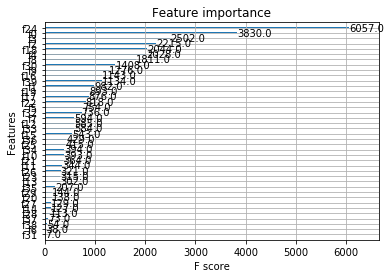

In [180]:
cnt1 = 0
cnt2 = 0
for i in range(len(y_test)):
    if ans[i] == y_test.to_numpy()[i]:
        cnt1 += 1
    else:
        cnt2 += 1

print("Accuracy: %.2f %% " % (100 * cnt1 / (cnt1 + cnt2)))
print('AUC score',roc_auc_score(y_test.to_numpy(), ans))


plot_importance(model)
plt.show()

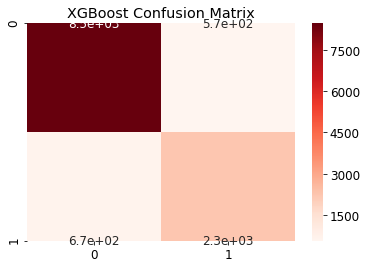

In [209]:
cm=confusion_matrix(y_test,ans)
cm
sns.heatmap(pd.DataFrame(cm),annot=True,cmap="Reds")
plt.title("XGBoost Confusion Matrix")
plt.show()

In [81]:
dtest = xgb.DMatrix(clean_test_X.to_numpy())
ans = model.predict(dtest)

In [87]:
sample = pd.read_csv('sample_submission.csv')

In [89]:
sample['income']=[int(label) for label in ans]

In [91]:
sample.to_csv('output.csv',index=False)

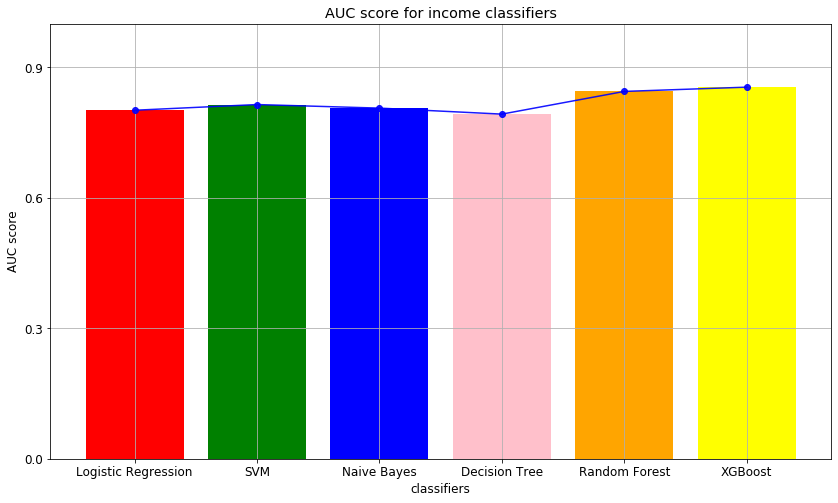

In [203]:
from matplotlib import pyplot as plt
#plt.figure(figsize=(14,7))
methods = ["Logistic Regression", "SVM", "Naive Bayes", "Decision Tree", "Random Forest","XGBoost"]
score = [0.8015, 0.8146, 0.8064, 0.7926, 0.8448, 0.8546]
plt.figure(figsize=(14,8))
plt.plot(range(len(methods)),score, '-o',color='blue',alpha = 0.9)

plt.bar(x=methods, height=score,color=['red','green','b','pink','orange', 'yellow'])
plt.xticks()
plt.ylim((0,1))
plt.yticks(np.arange(0,1.1,0.3))
plt.title('AUC score for income classifiers')
plt.xlabel('classifiers')
plt.ylabel('AUC score')

plt.grid(True)
plt.show()

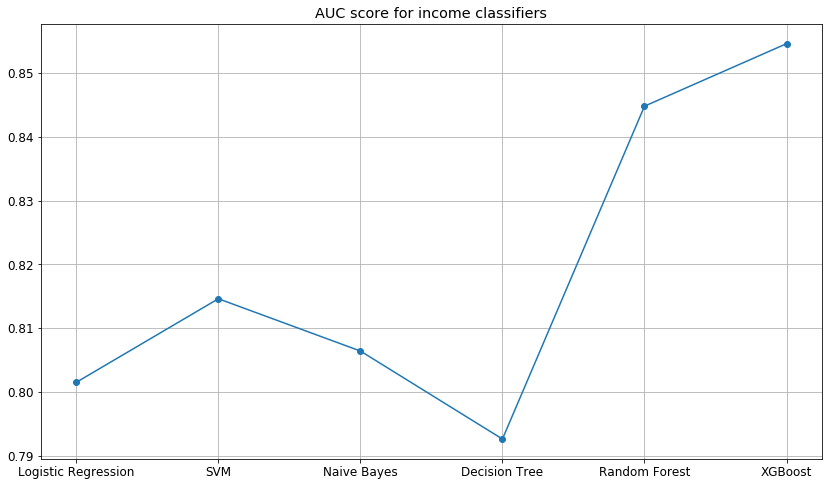

In [205]:
methods = ["Logistic Regression", "SVM", "Naive Bayes", "Decision Tree", "Random Forest","XGBoost"]
score = [0.8015, 0.8146, 0.8064, 0.7926, 0.8448, 0.8546]
plt.figure(figsize=(14,8))
plt.plot(range(len(methods)),score, '-o')

plt.xticks(range(0,6,1),labels = methods)
plt.title('AUC score for income classifiers')
plt.grid(visible=True)

plt.show()

In [206]:
# Predicted values
y_head_lr = logreg.predict(X_test)
y_head_svm = svm.predict(X_test)
y_head_nb = nb.predict(X_test)
y_head_dtc = dtc.predict(X_test)
y_head_rf = rf.predict(X_test)
y_head_xgb = ans

In [207]:
from sklearn.metrics import confusion_matrix
y_test = y_test.to_numpy()
cm_lr = confusion_matrix(y_test,y_head_lr)
cm_svm = confusion_matrix(y_test,y_head_svm)
cm_nb = confusion_matrix(y_test,y_head_nb)
cm_dtc = confusion_matrix(y_test,y_head_dtc)
cm_rf = confusion_matrix(y_test,y_head_rf)
cm_xgb = confusion_matrix(y_test,y_head_xgb)

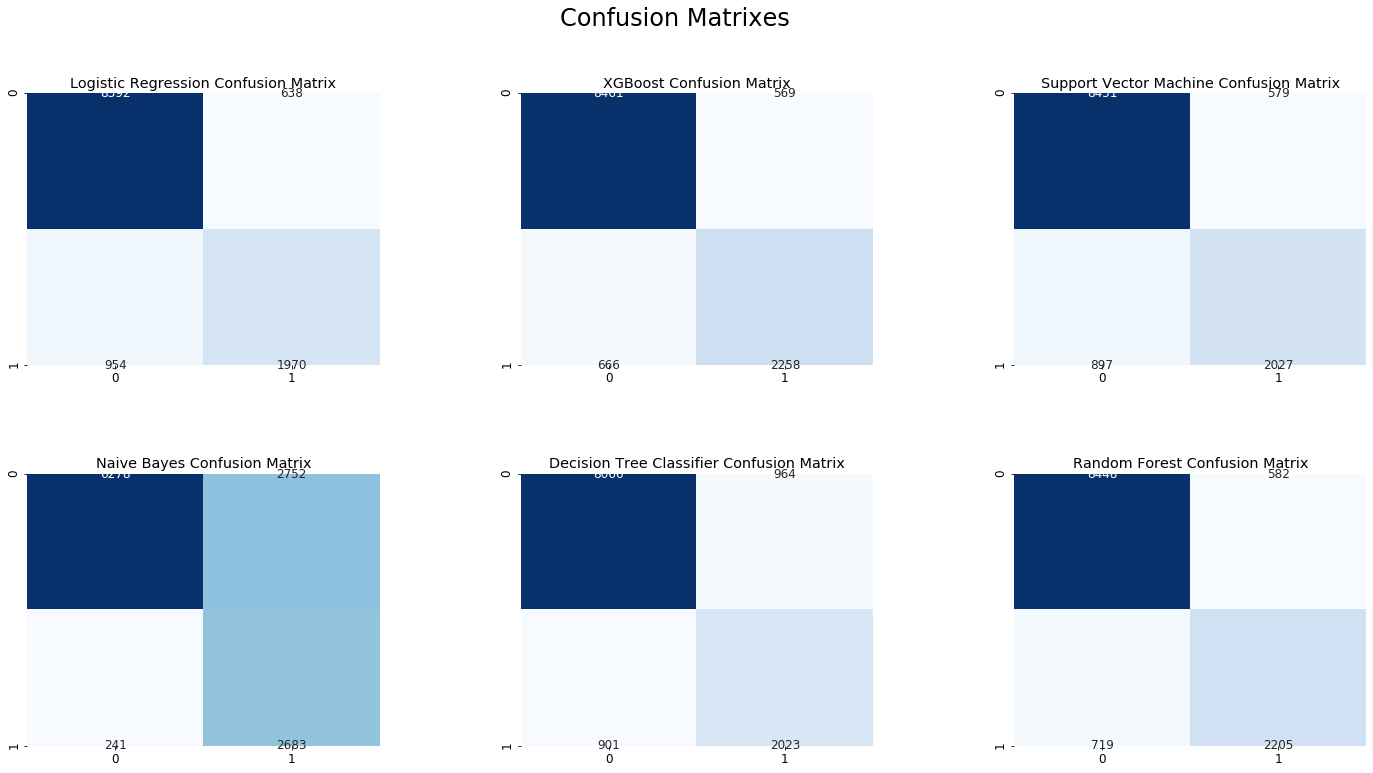

In [208]:
plt.figure(figsize=(24,12))

plt.suptitle("Confusion Matrixes",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(2,3,2)
plt.title("XGBoost Confusion Matrix")
sns.heatmap(cm_xgb,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(2,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(2,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(2,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.subplot(2,3,6)
plt.title("Random Forest Confusion Matrix")
sns.heatmap(cm_rf,annot=True,cmap="Blues",fmt="d",cbar=False)

plt.show()